In [1]:
import csv
import linecache
import datetime
import sys
import numpy as np
import random
from scipy.sparse import *
from scipy import *
import scipy as sp
import matplotlib.pyplot as plt
import os.path
import matplotlib
import copy
import pandas as pd
from scipy import stats
from tempfile import TemporaryFile
import pickle
def flushPrint(variable):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % variable)
    sys.stdout.flush()
    

### 读取2016年的流量数据并与2020最新部分比例数据合并

In [2]:
#读取工作簿和工作簿中的工作表
df=pd.read_csv('city_flow_v1.csv')
df.head(10)


,pi,pj,loni,lati,cityi.id,provi.id,lonj,latj,cityj.id,provj.id,flowij,distij,sameprov
0,1220637,1220637,116.412574,40.185609,110000,110000,116.412574,40.185609,110000,110000,1082923,0.000000,1
1,1220637,488412,116.412574,40.185609,110000,110000,117.344841,39.284732,120000,120000,4642,128.019884,0
2,1220637,371707,116.412574,40.185609,110000,110000,114.439494,38.130579,130100,130000,2962,284.863566,0
3,1220637,188880,116.412574,40.185609,110000,110000,118.335459,39.713888,130200,130000,1632,172.096010,0
4,1220637,82307,116.412574,40.185609,110000,110000,119.187239,40.085314,130300,130000,1021,236.130974,0
5,1220637,214644,116.412574,40.185609,110000,110000,114.542925,36.552456,130400,130000,3332,435.600363,0
6,1220637,138234,116.412574,40.185609,110000,110000,114.816896,37.212320,130500,130000,1873,358.424618,0
7,1220637,293124,116.412574,40.185609,110000,110000,115.171130,39.021666,130600,130000,6091,167.515139,0
8,1220637,87130,116.412574,40.185609,110000,110000,115.031804,40.864962,130700,130000,2891,139.016370,0
9,1220637,61064,116.412574,40.185609,110000,110000,117.547029,41.347208,130800,130000,1866,160.655042,0


In [3]:
cityi = list(df['cityi.id'])
cityj = list(df['cityj.id'])
all_cities = set(cityi+cityj)
cities_temp = {}
flows = {}
for n,i in enumerate(df.iterrows()):
    if n % 1000 == 0:
        flushPrint(n/len(df))
    cityi=long(i[1]['cityi.id'])
    cityj=long(i[1]['cityj.id'])
    provi=long(i[1]['provi.id'])
    provj=long(i[1]['provj.id'])
    cities_temp[cityi] = {'id':cityi,'lon':i[1]['loni'],'lat':i[1]['lati'],'provid':provi,'pop':i[1]['pi']}
    cities_temp[cityj] = {'id':cityj,'lon':i[1]['lonj'],'lat':i[1]['latj'],'provid':provj,'pop':i[1]['pj']}
    value = flows.get((cityi,cityj),0)
    flows[(cityi,cityj)] = value + i[1]['flowij']
    
    

0.995342957403680654

In [4]:
#存储到流量矩阵matrix
nodes_temp={} #cityid: row index mapping
matrix = np.zeros([len(cities_temp), len(cities_temp)])
self_flux = np.zeros(len(cities_temp))
pij1 = np.zeros([len(cities_temp), len(cities_temp)])
for key,value in flows.items():
    id1 = nodes_temp.get(key[0],-1)
    if id1<0:
        id1 = len(nodes_temp)
        nodes_temp[key[0]] = len(nodes_temp)
    id2 = nodes_temp.get(key[1],-1)
    if id2<0:
        id2 = len(nodes_temp)
        nodes_temp[key[1]] = len(nodes_temp)
    matrix[id1, id2] = value
for i in range(matrix.shape[0]):
    self_flux[i] = matrix[i, i]
    matrix[i, i] = 0
    if np.sum(matrix[i,:])>0:
        pij1[i,:]=matrix[i,:]/np.sum(matrix[i,:])
#根据我国人口总数，核算每个城市的人口数以及总流动人口占比
all_pop = np.sum(np.array([v['pop'] for k,v in cities_temp.items()]))
china_pop = 13*1e8
frac = china_pop / all_pop
for k,v in cities_temp.items():
    cities_temp[k]['pop'] = frac * v['pop']
flowing_ratio=np.sum(matrix) / all_pop


#### 读取每个城市id与name的映射

In [5]:
df=pd.read_csv('county_city_province.csv')
df.head(10)


,COUNTY_ID,COUNTY,CITY_ID,CITY,PROV_ID,PROV
0,110101,东城区,110000,北京市,110000,北京市
1,110102,西城区,110000,北京市,110000,北京市
2,110105,朝阳区,110000,北京市,110000,北京市
3,110106,丰台区,110000,北京市,110000,北京市
4,110107,石景山区,110000,北京市,110000,北京市
5,110108,海淀区,110000,北京市,110000,北京市
6,110109,门头沟区,110000,北京市,110000,北京市
7,110111,房山区,110000,北京市,110000,北京市
8,110112,通州区,110000,北京市,110000,北京市
9,110113,顺义区,110000,北京市,110000,北京市


In [6]:
id_to_city={}
for i in df.iterrows():
    id_to_city[i[1]['CITY_ID']]={'city':i[1]['CITY'],'prov':i[1]['PROV']}
city_properties = {}
nodes = {}
for k,v in cities_temp.items():
    new_property = id_to_city.get(k, {'city':str(k), 'prov':str(k)})
    v['prov'] = new_property['prov']
    city_properties[new_property['city']] = v
    row_idx = nodes_temp.get(v['id'],-1)
    if row_idx >= 0:
        nodes[new_property['city']] = row_idx
    else:
        print(new_property['city'])
        

In [7]:
nodes


{'北京市': 0,
 '天津市': 1,
 '石家庄市': 2,
 '唐山市': 3,
 '秦皇岛市': 4,
 '邯郸市': 5,
 '邢台市': 6,
 '保定市': 7,
 '张家口市': 8,
 '承德市': 9,
 '沧州市': 10,
 '廊坊市': 11,
 '衡水市': 12,
 '太原市': 13,
 '大同市': 14,
 '阳泉市': 15,
 '长治市': 16,
 '晋城市': 17,
 '朔州市': 18,
 '晋中市': 19,
 '运城市': 20,
 '忻州市': 21,
 '临汾市': 22,
 '吕梁市': 23,
 '呼和浩特市': 24,
 '包头市': 25,
 '乌海市': 26,
 '赤峰市': 27,
 '通辽市': 28,
 '鄂尔多斯市': 29,
 '呼伦贝尔市': 30,
 '巴彦淖尔市': 31,
 '乌兰察布市': 32,
 '兴安盟': 33,
 '锡林郭勒盟': 34,
 '阿拉善盟': 35,
 '沈阳市': 36,
 '大连市': 37,
 '鞍山市': 38,
 '抚顺市': 39,
 '本溪市': 40,
 '丹东市': 41,
 '锦州市': 42,
 '营口市': 43,
 '阜新市': 44,
 '辽阳市': 45,
 '盘锦市': 46,
 '铁岭市': 47,
 '朝阳市': 48,
 '葫芦岛市': 49,
 '长春市': 50,
 '吉林市': 51,
 '四平市': 52,
 '辽源市': 53,
 '通化市': 54,
 '白山市': 55,
 '松原市': 56,
 '白城市': 57,
 '延边朝鲜族自治州': 58,
 '哈尔滨市': 59,
 '齐齐哈尔市': 60,
 '鸡西市': 61,
 '鹤岗市': 62,
 '双鸭山市': 63,
 '大庆市': 64,
 '伊春市': 65,
 '佳木斯市': 66,
 '七台河市': 67,
 '牡丹江市': 68,
 '黑河市': 69,
 '绥化市': 70,
 '大兴安岭地区': 71,
 '上海市': 72,
 '南京市': 73,
 '无锡市': 74,
 '徐州市': 75,
 '常州市': 76,
 '苏州市': 77,
 '南通市': 78,
 '连云港市': 79,
 '淮安市': 80,
 '盐城市

#### 读取2020年的百度部分流量比例数据 

In [8]:
df=pd.read_csv('Pij_BAIDU.csv',encoding='gbk')
df.head(10)


,Cities,北京市,天津市,石家庄市,唐山市,秦皇岛市,邯郸市,邢台市,保定市,张家口市,...,和田地区,伊犁哈萨克自治州,塔城地区,阿勒泰地区,石河子市,阿拉尔市,五家渠市,香港特别行政区,澳门特别行政区,Unnamed: 352
0,北京市,inf,11.855277,5.725960,12.749903,9.573570,6.598759,4.861948,27.363624,37.854040,...,0.729644,0.424284,0.146950,0.244898,0.284529,0.192485,0.109344,1.716803,1.431816,NaN
1,天津市,4.458202,inf,1.806775,20.849449,5.471267,5.470594,1.854504,3.523714,3.469709,...,0.527886,0.085204,0.012593,0.069344,0.005139,0.027000,0.026867,0.228988,0.325382,NaN
2,石家庄市,2.230990,1.815094,inf,3.832100,3.980366,11.405949,30.187961,15.307815,5.608304,...,0.000000,0.081481,0.003760,0.000000,0.075537,0.006981,0.044484,0.012442,0.007495,NaN
3,唐山市,1.755526,6.625320,2.427825,inf,23.561492,1.150411,0.838385,1.560130,2.586040,...,0.000000,0.000000,0.000000,0.000000,0.012455,0.000000,0.000000,0.000000,0.074082,NaN
4,秦皇岛市,0.743911,1.104723,0.999676,12.371138,inf,0.347803,0.232399,0.585399,0.724584,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
5,邯郸市,3.058310,3.685172,9.266465,2.033850,1.596207,inf,18.648848,2.832027,1.373215,...,0.000000,0.010470,0.000000,0.000000,0.040079,0.000000,0.000000,0.000000,0.000000,NaN
6,邢台市,1.784559,1.592507,17.716423,1.595459,1.481331,17.228512,inf,2.246571,1.065858,...,0.009354,0.031075,0.004738,0.000000,0.034814,0.009440,0.009669,0.000000,0.000000,NaN
7,保定市,7.296308,3.120498,14.208043,3.131967,2.768861,2.910327,2.589855,inf,5.916331,...,0.000000,0.007716,0.005211,0.017470,0.010746,0.000000,0.027492,0.000000,0.000000,NaN
8,张家口市,3.680067,1.204148,2.334679,1.417932,1.110539,0.612830,0.439005,2.174117,inf,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005701,0.000000,0.000000,NaN
9,承德市,2.454110,0.976658,1.627907,6.065174,3.048455,0.362100,0.222737,1.148757,2.144588,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.004509,0.000000,0.000000,0.000000,NaN


In [9]:
cities = {d:i for i,d in enumerate(df['Cities'])}
pij2 = np.zeros([len(nodes), len(nodes)])
for k,ind in cities.items():
    row = df[k]
    for city,column in cities.items():
        i_indx = nodes.get(city, '-1')
        if i_indx < 0:
            print(city)
        j_indx = nodes.get(k, '-1')
        if j_indx < 0:
            print(k)
        if i_indx >=0 and j_indx >= 0:
            pij2[j_indx, i_indx] = row[column] / 100
            if i_indx == j_indx:
                pij2[i_indx, j_indx] = 0
pij2


array([[0.00000000e+00, 4.45820151e-02, 2.23099039e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.18552769e-01, 0.00000000e+00, 1.81509430e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.72596015e-02, 1.80677508e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.71680253e-02, 2.28988485e-03, 1.24418856e-04, ...,
        0.00000000e+00, 0.00000000e+00, 2.05991973e-02],
       [1.43181560e-02, 3.25381944e-03, 7.49467787e-05, ...,
        0.00000000e+00, 1.74395725e-02, 0.00000000e+00]])

#### 将pij1和pij2合并
合并思路，如果ij元素中pij2有值就用pij2的，否则将这一行所有的未被替换的pij1的值重新按照这些非零元素的数值大小计算占比，然后用1-$\sum_{j}p_{ij2}$的总值乘以这个占比，从而得到新的数值，保证$\sum_{j}p_{ij}=1$

In [10]:
bools = pij2 <= 0
pij = np.zeros([pij1.shape[0], pij1.shape[0]])
for i in range(pij1.shape[0]):
    row = pij1[i]
    bool1 = bools[i]
    values = row * bool1
    if np.sum(values) > 0:
        ratios = values / np.sum(values)
        sum2 = np.sum(pij2[i, :])
        pij[i,:] = (1 - sum2) * ratios + pij2[i, :]
np.sum(pij,1) #验证一下是否归一化


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [12]:
f = open('pij.pkl', 'wb')
pickle.dump(pij, f, pickle.HIGHEST_PROTOCOL)
f.close()
f = open('nodes.pkl', 'wb')
pickle.dump(nodes, f, pickle.HIGHEST_PROTOCOL)
f.close()

f = open('city_info.pkl', 'wb')
pickle.dump(city_properties, f, pickle.HIGHEST_PROTOCOL)
f.close()


### 如果没有原始数据，可以从这里开始
加载数据:pij, nodes, city_properties

In [20]:
f = open('pij.pkl', 'rb')
pij = pickle.load(f)
f.close()
f = open('nodes.pkl', 'rb')
nodes = pickle.load(f)
f.close()
f = open('city_info.pkl', 'rb')
city_properties = pickle.load(f)
f.close()
flowing_ratio = 0.1255

### 读取病例数据

In [46]:
reader=pd.ExcelFile('city_cases.xlsx')
df = reader.parse("Sheet1")
df


,确诊/出院,公开报道时间,省份,城市,新增确诊病例,新增治愈出院数,新增死亡数,消息来源,来源链接1,来源链接2,来源链接3
0,2020-01-28,2020-01-29,湖北,武汉市,315,0,19,湖北卫健委,http://wjw.hubei.gov.cn/fbjd/dtyw/202001/t2020...,NaN,NaN
1,2020-01-28,2020-01-29,湖北,黄石市,33,0,0,湖北卫健委,http://wjw.hubei.gov.cn/fbjd/dtyw/202001/t2020...,NaN,NaN
2,2020-01-28,2020-01-29,湖北,十堰市,23,0,0,湖北卫健委,http://wjw.hubei.gov.cn/fbjd/dtyw/202001/t2020...,NaN,NaN
3,2020-01-28,2020-01-29,湖北,襄阳市,61,0,0,湖北卫健委,http://wjw.hubei.gov.cn/fbjd/dtyw/202001/t2020...,NaN,NaN
4,2020-01-28,2020-01-29,湖北,宜昌市,12,0,0,湖北卫健委,http://wjw.hubei.gov.cn/fbjd/dtyw/202001/t2020...,NaN,NaN
5,2020-01-28,2020-01-29,湖北,荆州市,30,0,0,湖北卫健委,http://wjw.hubei.gov.cn/fbjd/dtyw/202001/t2020...,NaN,NaN
6,2020-01-28,2020-01-29,湖北,荆门市,28,0,1,湖北卫健委,http://wjw.hubei.gov.cn/fbjd/dtyw/202001/t2020...,NaN,NaN
7,2020-01-28,2020-01-29,湖北,鄂州市,27,0,1,湖北卫健委,http://wjw.hubei.gov.cn/fbjd/dtyw/202001/t2020...,NaN,NaN
8,2020-01-28,2020-01-29,湖北,孝感市,101,0,2,湖北卫健委,http://wjw.hubei.gov.cn/fbjd/dtyw/202001/t2020...,NaN,NaN
9,2020-01-28,2020-01-29,湖北,黄冈市,111,0,1,湖北卫健委,http://wjw.hubei.gov.cn/fbjd/dtyw/202001/t2020...,NaN,NaN


2020-01-10 00:00:00 39


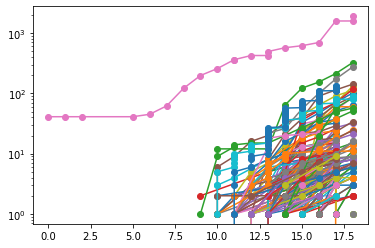

In [47]:
all_cases_cities = list(set(df['城市']))[1:]
all_cases_cities = all_cases_cities + ['北京市','天津市','重庆市','上海市']
#print(all_cases_cities)
wuhan=df.loc[df['城市']=='武汉市',['新增确诊病例','确诊/出院','公开报道时间','新增治愈出院数','新增死亡数']]
dates = list(wuhan['确诊/出院'])
sorted_dates = np.sort(dates)
first_date = sorted_dates[0]
first_cases = 39
print(first_date, first_cases)

all_cases = {}

for city in all_cases_cities:
    subset = df.loc[df['城市']==city,['新增确诊病例','确诊/出院','公开报道时间','新增治愈出院数','新增死亡数','省份']]
    zhixia = False
    if len(subset)==0:
        subset = df.loc[df['省份']==city[:-1],['新增确诊病例','确诊/出院','公开报道时间','新增治愈出院数','新增死亡数','省份']]
        zhixia = True
    new_cases = np.array(subset['新增确诊病例'])
    cued_cases = np.array(subset['新增治愈出院数'])
    die_cases = np.array(subset['新增死亡数'])
    dates = list(subset['确诊/出院'])
    dates1 = list(subset['公开报道时间'])
    days = []
    for i,dd in enumerate(dates):
        if pd.isna(dd):
            dd = dates1[i]
        if not pd.isna(dd):
            days.append(int((dd - first_date)/ np.timedelta64(1, 'D')))
    sorted_days = np.sort(days)
    indx = np.argsort(days)
    infected = np.cumsum(new_cases[indx])
    cued = np.cumsum(cued_cases[indx])
    death = np.cumsum(die_cases[indx])
    if len(sorted_days)>0:
        if zhixia:
            all_cases[list(subset['省份'])[0]+'市']= (sorted_days, infected, cued, death)
        else:
            all_cases[city] = (sorted_days, infected, cued, death)
for case in all_cases.values():
    xx = case[0]
    yy = case[1]
    if len(yy) > 0:
        plt.semilogy(xx,yy,'o-')
plt.show()


In [48]:
wuhan


,新增确诊病例,确诊/出院,公开报道时间,新增治愈出院数,新增死亡数
0,315,2020-01-28,2020-01-29,0,19
83,892,2020-01-27,2020-01-28,0,22
199,0,2020-01-28,2020-01-28,3,0
262,80,2020-01-26,2020-01-27,2,18
476,46,2020-01-25,2020-01-26,8,7
649,77,2020-01-24,2020-01-25,1,15
837,70,2020-01-23,2020-01-24,0,6
936,0,2020-01-23,2020-01-24,3,0
1019,0,2020-01-21,2020-01-22,3,3
1022,105,2020-01-21,2020-01-22,0,0


In [35]:
cued = 0
death = 0
for k,itms in all_cases.items():
    cued += np.sum(itms[2])
    death += np.sum(itms[3])
death_ratio = death / (death+cued)
death_ratio

0.3601036269430052

In [8]:
# #读取工作簿和工作簿中的工作表
# reader=pd.ExcelFile('Wuhan_nCoV202001241408.xlsx')
# df = reader.parse("汇总表格")
# all_cases_cities = list(set(df['地级行政单位']))[1:]
# wuhan=df.loc[df['地级行政单位']=='武汉',['病例数','发病日期','确诊日期','地级行政单位']]
# dates = list(wuhan['发病日期'])
# first_date = dates[0]
# print(first_date)

# all_cases = {}
# for city in all_cases_cities:
#     subset = df.loc[df['地级行政单位']==city,['病例数','发病日期','确诊日期']]
#     a = np.array(subset['病例数'])
#     dates = list(subset['发病日期'])
#     dates1 = list(subset['确诊日期'])

#     days = []
#     for i,dd in enumerate(dates):
#         #if pd.isna(dd):
#         #    dd = dates1[i]
#         if not pd.isna(dd):
#             days.append(int((dd - first_date)/ np.timedelta64(1, 'D')))
#     sorted_days = np.sort(days)
#     indx = np.argsort(days)
#     infected = np.cumsum(a[indx])
#     if len(sorted_days)>0:
#         all_cases[city] = (sorted_days, infected)
# for case in all_cases.values():
#     xx = case[0]
#     yy = case[1]
#     if len(yy) > 0:
#         plt.semilogy(xx,yy,'o-')
# plt.show()

## 有效距离

为了计算有效距离，需要重新修改矩阵乘积的法则，基本思路就是在计算概率的时候，要把加法变为求大，计算距离的时候，要求小

In [9]:
def my_matrix_production(matrix, matrix1):
    #特殊的矩阵乘积，将加法转换为取大
    sz = matrix.shape[0]
    output = np.zeros([sz, sz])
    for i in range(sz):
        for j in range(sz):
            row = matrix[i, :]
            col = matrix1[:, j].reshape(-1)
            prod = row * col
            ele = np.amax(prod)
            output[i,j]=ele
    return output
def eff_distance(prob):
    #输入迁移概率矩阵，计算有效距离
    sz = prob.shape[0]
    prod = prob
    distance = np.ones([sz, sz]) - np.log(prod)
    for i in range(1, sz - 1):
        flushPrint(i / sz)
        prod = my_matrix_production(prod, prob)
        dist = i + 1 - np.log(prod)
        distance = np.minimum(distance, dist)
    return distance


### 利用概率转移矩阵，计算有效距离

In [10]:
effective_distance = eff_distance(pij)


0.0026954177897574125

/Users/zhangjiang/anaconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


0.005390835579514825

/Users/zhangjiang/anaconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


0.994609164420485276

In [ ]:
#outfile = open('effective_distance.npy', 'w')
outfile = TemporaryFile()
np.save(outfile, effective_distance)


#### 计算出武汉到每个城市的有效距离

距离排序并显示

In [11]:
eff_dist = copy.deepcopy(effective_distance)
for i in range(len(nodes)):
    eff_dist[i,i]=np.inf
    

In [12]:
rowid = nodes['武汉市']
sorted_distance = np.sort(eff_dist[rowid,:])
sorted_cities = np.argsort(eff_dist[rowid,:])
sorted_flux = np.sort(pij[rowid,:])[::-1]
sorted_flux_cities = np.argsort(pij[rowid,:])[::-1]


In [13]:
def find_in_nodes(ind, nodes):
    key = -1
    for k,v in nodes.items():
        if v == ind:
            key = k
            break
    return key
firsts=[]
firsts_dis=[]
city_names_dis=[]
for n, i in enumerate(sorted_cities):
    city_name = find_in_nodes(i, nodes)
    itm = all_cases.get(city_name,[])
    if len(itm)==0:
        itm = all_cases.get(city_name[:-1],[])
    if len(itm)>0:
        firsts.append(itm[0][0])
        firsts_dis.append(sorted_distance[n])
        city_names_dis.append(city_name)
    print(city_name, sorted_distance[n])
    

孝感市 2.980478616994291
黄冈市 3.037374727396292
荆州市 3.7266514129156585
咸宁市 3.9941694566455666
鄂州市 4.227351434727007
襄阳市 4.237179631878021
黄石市 4.2789522017520465
荆门市 4.412218955904846
随州市 4.438999246796143
仙桃市 4.516069097497828
宜昌市 4.573724208503557
天门市 4.870426215772632
十堰市 4.9832323597688095
恩施土家族苗族自治州 5.009988507377806
信阳市 5.208159052890949
重庆市 5.367613802259018
潜江市 5.473031232823582
长沙市 5.587191788867874
北京市 5.751427751255027
南阳市 5.974024661804292
上海市 6.016305320813929
驻马店市 6.026172347218409
郑州市 6.137315133661776
九江市 6.256416329600447
岳阳市 6.259292709764764
深圳市 6.301076903215052
广州市 6.30256274134972
南昌市 6.348199251019906
成都市 6.373804595803513
佛山市 6.384934319113159
安庆市 6.394024560113519
周口市 6.425457483154485
合肥市 6.530407853420411
阜阳市 6.66392870136436
西安市 6.6940627053281245
常德市 6.700480538613006
商丘市 6.727501410718335
无锡市 6.733241013381375
金华市 6.842440305346367
青岛市 6.912120225984356
中山市 6.9399965955126115
台州市 7.009494390009533
衡阳市 7.030037124252194
南京市 7.0362446213511936
常州市 7.0841852826111

In [14]:
for n, i in enumerate(sorted_flux_cities):
    city_name = find_in_nodes(i, nodes)
    print(city_name, sorted_flux[n])
    

孝感市 0.13800317083905633
黄冈市 0.13037052016575537
荆州市 0.06543804820074638
咸宁市 0.05007820193715937
鄂州市 0.03966240827445952
襄阳市 0.03927450761093604
黄石市 0.03766770429162578
荆门市 0.03296796469263517
随州市 0.0320967902262938
仙桃市 0.029716016646751817
宜昌市 0.028051190425461746
天门市 0.020849481153469657
十堰市 0.01862533813897044
恩施土家族苗族自治州 0.018133603638259162
信阳市 0.014873724890215378
重庆市 0.012681464976035053
潜江市 0.011412668908960049
长沙市 0.010181409813749945
北京市 0.008639351548367402
南阳市 0.006915260368904351
上海市 0.006628973450304621
驻马店市 0.006563886828005163
郑州市 0.0058734379587736365
九江市 0.005213956379182629
岳阳市 0.005198980606808488
深圳市 0.004986221336771881
广州市 0.00497881812031449
南昌市 0.004756708930511282
成都市 0.004636457863310777
佛山市 0.004585141468508556
安庆市 0.004543650295628987
周口市 0.004403051379144688
合肥市 0.003964371876690988
阜阳市 0.003468861969953192
西安市 0.0033658905323423194
常德市 0.0033443579781300514
商丘市 0.003255200490097933
无锡市 0.00323657044835898
金华市 0.0029017528157701204
青岛市 0.0027064425300932855


Text(0, 0.5, 'pij')

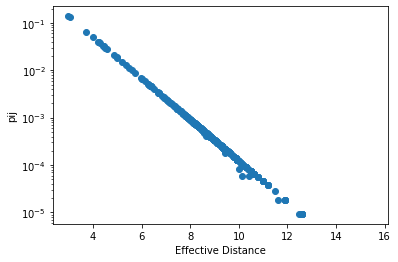

In [15]:
plt.semilogy(eff_dist[rowid,:],pij[rowid,:],'o')
plt.xlabel('Effective Distance')
plt.ylabel('pij')


#### 与流量排序做比较

In [16]:
for i,name in enumerate(city_names_dis):
    print(i,name,firsts[i],firsts_dis[i])
    
    

0 孝感市 13 2.980478616994291
1 黄冈市 10 3.037374727396292
2 荆州市 12 3.7266514129156585
3 咸宁市 15 3.9941694566455666
4 鄂州市 14 4.227351434727007
5 襄阳市 15 4.237179631878021
6 黄石市 15 4.2789522017520465
7 荆门市 11 4.412218955904846
8 随州市 14 4.438999246796143
9 仙桃市 13 4.516069097497828
10 宜昌市 13 4.573724208503557
11 天门市 14 4.870426215772632
12 十堰市 13 4.9832323597688095
13 信阳市 13 5.208159052890949
14 重庆市 11 5.367613802259018
15 潜江市 16 5.473031232823582
16 长沙市 10 5.587191788867874
17 北京市 10 5.751427751255027
18 南阳市 14 5.974024661804292
19 上海市 10 6.016305320813929
20 驻马店市 14 6.026172347218409
21 郑州市 11 6.137315133661776
22 九江市 13 6.256416329600447
23 岳阳市 13 6.259292709764764
24 深圳市 9 6.301076903215052
25 广州市 11 6.30256274134972
26 南昌市 12 6.348199251019906
27 成都市 10 6.373804595803513
28 佛山市 11 6.384934319113159
29 安庆市 13 6.394024560113519
30 周口市 13 6.425457483154485
31 合肥市 11 6.530407853420411
32 阜阳市 13 6.66392870136436
33 西安市 13 6.6940627053281245
34 常德市 14 6.700480538613006
35 商丘市 16 6.727501410718335

### 有效距离和首感日期的比较

0.343289817860591 0.4305486525111803


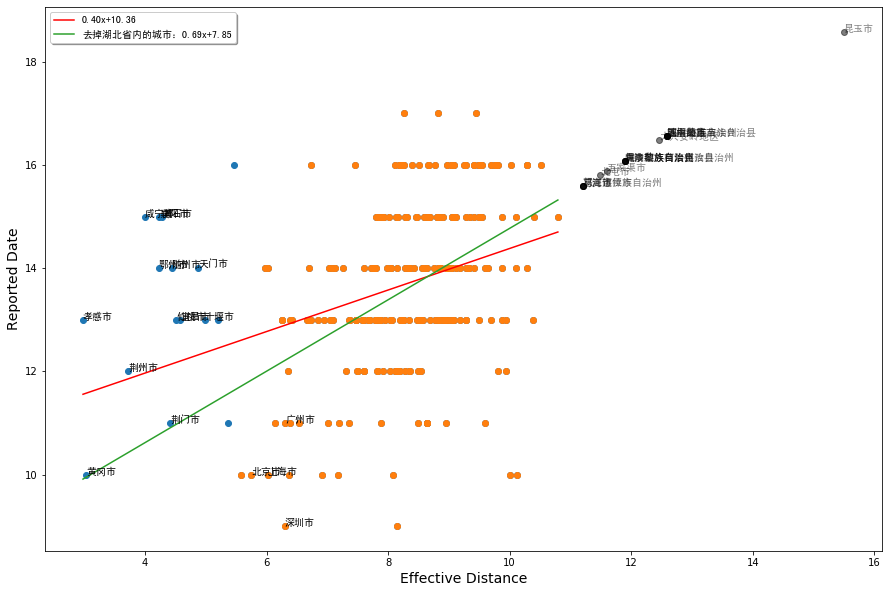

In [17]:

yy=np.array(firsts)*1.0
xx=np.array(firsts_dis)
bools=(xx!=inf)#&(xx>5.5)
plt.figure(figsize=(15,10))

slope, intercept, r_value, p_value, std_err = stats.linregress(xx[bools],yy[bools])
#slope1, intercept1, _,_,_ = stats.linregress(yy[bools],xx[bools])
bools1 = (xx!=inf)&(xx>5.5)
slope1, intercept1, r_value2,_,_ = stats.linregress(xx[bools1],yy[bools1])
print(r_value,r_value2)

bools2 = (sorted_distance!=inf)&(sorted_distance>=11)
plt.plot(sorted_distance[bools2], slope1 * sorted_distance[bools2] + intercept1, 'ko',alpha=0.5)
plt.plot(firsts_dis,firsts,'o')
plt.plot(xx[bools1],yy[bools1],'o')

plt.plot(xx[bools],slope*xx[bools]+intercept,'r-',label='{:2.2f}x+{:2.2f}'.format(slope,intercept))
#plt.plot(xx[bools],(1/slope1)*xx[bools]-intercept1/slope1,'-',label=
#         '颠倒x、y轴拟合：{:2.2f}x{:2.2f}'.format(1/slope1,-intercept1/slope1))
plt.plot(xx[bools],slope1*xx[bools]+intercept1,'-',
         label='去掉湖北省内的城市：{:2.2f}x+{:2.2f}'.format(slope1,intercept1))

zhfont1 = matplotlib.font_manager.FontProperties(fname='/Users/zhangjiang/Library/Fonts/SimHei.ttf', size=10)
show_cities = sorted_cities[bools2]
for n,i in enumerate(show_cities):
    xcor =sorted_distance[bools2][n]
    ycor = slope1 * xcor + intercept1
    #print(xcor, ycor)
    city_name = find_in_nodes(i, nodes)
    plt.text(xcor,ycor,city_name,fontproperties=zhfont1,alpha=0.5)
for i in range(13):
    plt.text(firsts_dis[i],firsts[i],city_names_dis[i],fontproperties=zhfont1)
plt.text(firsts_dis[17],firsts[17],city_names_dis[17],fontproperties=zhfont1)
plt.text(firsts_dis[19],firsts[19],city_names_dis[19],fontproperties=zhfont1)
plt.text(firsts_dis[24],firsts[24],city_names_dis[24],fontproperties=zhfont1)
plt.text(firsts_dis[25],firsts[25],city_names_dis[25],fontproperties=zhfont1)

plt.xlabel('Effective Distance',fontsize=14)
plt.ylabel('Reported Date',fontsize=14)
#plt.ylim([15, 50])
plt.legend(loc='upper left', shadow=True, numpoints = 1,fontsize=10,prop = zhfont1 )
plt.show()


# 传播模型

传播模型如下：


$\partial j_n/\partial t = \alpha s_n j_n - \beta j_n + \gamma \sum_{m\neq n}P_{mn}(j_m-j_n)$



$\partial s_n/\partial t = -\alpha s_n j_n + \gamma \sum_{m\neq n}P_{mn}(s_m-s_n)$


$r_n = 1 - s_n - j_n$

其中$j_n$是n城市感染比例；$s_n$是n城市疑似人群比例；$\alpha$为感染系数；$\beta$为康复系数；$\epsilon$为平均每城市人口数；$\gamma$为平均流动人口占总人口的比例；$P_{mn}$为从n城市到m城市的n城市流动人口占比。

在数值求解中，$\sum_{m\neq n}P_{mn}(j_m-j_n)$的计算用了矩阵和向量的乘法，并做了简化，即$\sum_{m\neq n}P_{mn}(j_m-j_n)=\sum_m P_{mn}j_m-j_n$，写成矩阵方程为：$j\cdot P - j$


In [18]:
from scipy.integrate import odeint

def protect_decay(t, t0, eta, rate_time):
    epsilon = 0.001
    r = 2 * np.log((1-epsilon)/epsilon) / rate_time
    x0 = t0 + rate_time/2
    decay = eta / (1 + np.exp(r * (t - x0))) + 1 - eta
    return decay
    
def diff(sicol, t, alpha, beta, gamma, eta, rate_time, protect_day, pijt, intervention):
    sz = sicol.shape[0] // 2
    js = sicol[:sz]
    ss = sicol[sz:]
    jterm = js.dot(pijt) - js
    sterm = ss.dot(pijt) - ss
    if intervention:
        cross_term = alpha * protect_decay(t, protect_day, eta, rate_time) * js * ss
    else:
        cross_term = alpha  * js * ss
    delta_i = cross_term - beta * js + gamma * jterm
    delta_s = - cross_term + gamma * sterm
    output = np.r_[delta_i, delta_s]
    return output


## 跑一下正式数据

其中各个参数取值按照Science论文中的数值，可以考虑带代入我国参数

#### 计算流量比例数据

0.1255
0.736842105263158


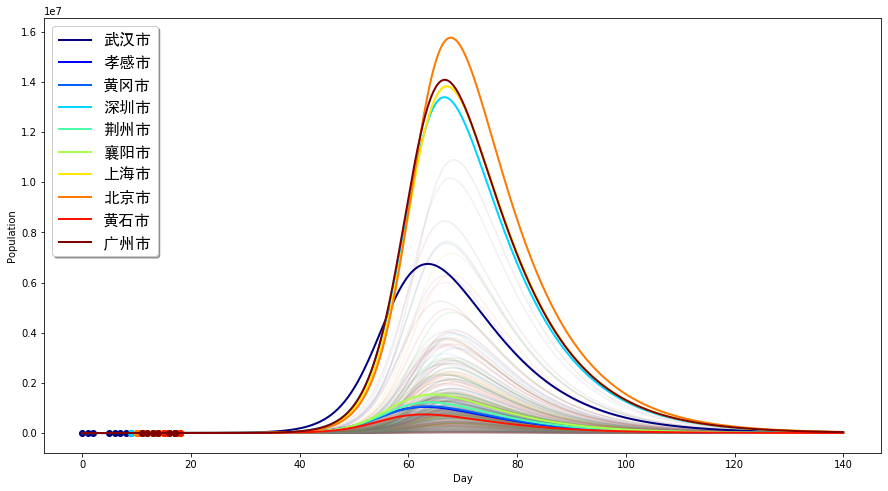

In [102]:
timespan = np.linspace(0, 200, 1000)
js0 = np.zeros(len(nodes))
ss0 = np.ones(len(nodes))
js0[nodes['武汉市']] = float(first_cases)/float(city_properties['武汉市']['pop'])#1e-4
r0=3.8
beta = 1/10 #一个病患从确诊到治愈（死亡）假设平均需要10天
alpha = r0 * beta

gamma = flowing_ratio
print(gamma)

eta = (1-1.0/r0)
print(eta)
rate_time = 30
#武汉封城1月23日，数据起始日：1月10日
result = odeint(diff, np.r_[js0,ss0], timespan, args = (alpha, beta, gamma, eta, 
                                                        rate_time, 13, np.transpose(pij),False))

cities = ['武汉市','孝感市','黄冈市','深圳市','荆州市','襄阳市','上海市','北京市','黄石市','广州市']

plt.figure(figsize = (15,8))
plot_time_span = 700
for i in range(result.shape[1]//2):
    for k,v in nodes.items():
        if v == i:
            cityname = k
    plt.plot(timespan[:plot_time_span],result[:plot_time_span,i]*city_properties[cityname]['pop']
             ,alpha=0.1)
colors = plt.cm.jet(np.linspace(0,1,len(cities)))
for n,i in enumerate(cities):
    cityname = i
    if cityname[-1]=='市':
        cityname1 = cityname[:-1]
    itm = all_cases.get(cityname1,[])
    if len(itm)==0:
        itm = all_cases.get(cityname,[])
    if len(itm)>0:
        idx = nodes.get(cityname,-1)
        if idx>=0:  
            plt.plot(timespan[:plot_time_span],result[:plot_time_span,idx]*city_properties[cityname]['pop']
                     ,color=colors[n],label=cityname,linewidth=2)
            infected_number = itm[1] - itm[2] - itm[3]
            plt.plot(itm[0], infected_number, 'o',color=colors[n])

zhfont1 = matplotlib.font_manager.FontProperties(fname='/Users/zhangjiang/Library/Fonts/SimHei.ttf', size=16)
plt.legend(loc='upper left', shadow=True, numpoints = 1,fontsize=10,prop = zhfont1 )
plt.xlabel('Day')
plt.ylabel('Population')
plt.show()


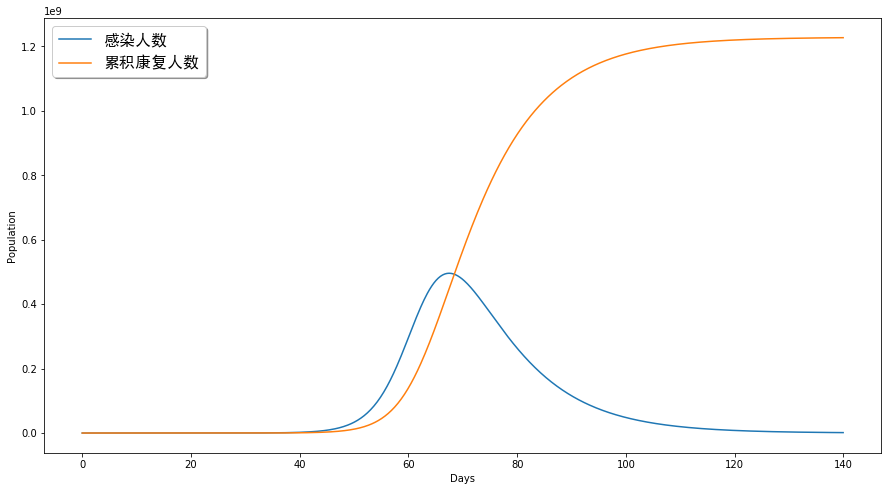

In [90]:
all_pop = np.zeros([result.shape[0]])
all_recovery = np.zeros([result.shape[0]])
for k,city in city_properties.items():
    idx = nodes[k]
    all_pop += result[:, idx] * city['pop']
    all_recovery += (1-result[:, idx]-result[:, len(nodes)+idx]) * city['pop']
plt.figure(figsize = (15,8))
country_pop = np.sum([city['pop'] for k,city in city_properties.items()])
plot_time_span = 700
plt.plot(timespan[:plot_time_span],all_pop[:plot_time_span],label='感染人数')
#plt.plot(timespan[:plot_time_span],all_recovery[:plot_time_span]*death_ratio, label='累积死亡人数')
plt.plot(timespan[:plot_time_span],all_recovery[:plot_time_span]*(1-death_ratio), label = '累积康复人数')
plt.xlabel('Days')
plt.ylabel('Population')
plt.legend(loc='upper left', shadow=True, numpoints = 1,fontsize=10,prop = zhfont1 )
plt.show()


### 建模干预的情况

建模思路是将原方程改为：

$\partial j_n/\partial t = \alpha \xi(t,t_0,t_m,\eta) s_n j_n - \beta j_n + \gamma \sum_{m\neq n}P_{mn}(j_m-j_n)$



$\partial s_n/\partial t = -\alpha \xi(t,t_0,t_m,\eta) s_n j_n + \gamma \sum_{m\neq n}P_{mn}(s_m-s_n)$


$r_n = 1 - s_n - j_n$

其中，

$\xi(t,t_0,t_m,\eta) = \frac{\eta}{1 + \exp(\lambda (t - t_0 - t_m/2))} + 1 - \eta$

这里，

$\lambda = 2 \frac{\log(\frac{1-\epsilon}{\epsilon})}{t_m}, \epsilon = 0.01$


0.1255
0.8947368421052632


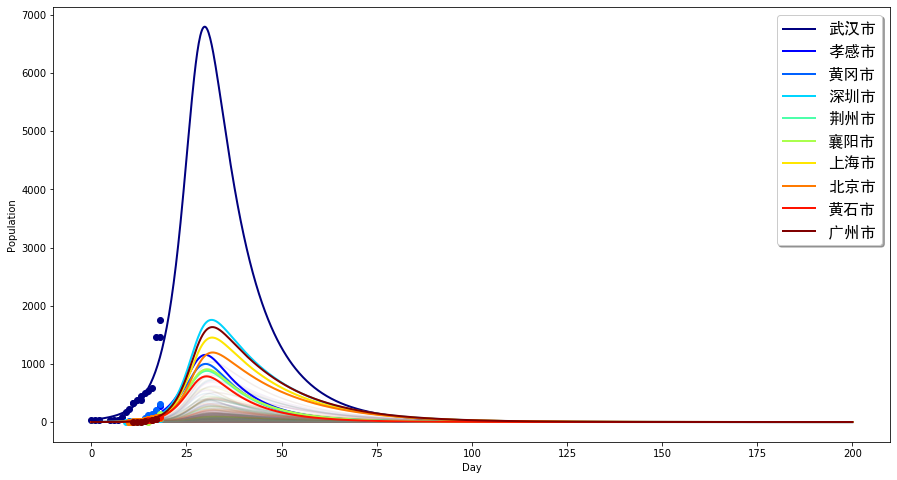

In [103]:
#有干预情况：

timespan = np.linspace(0, 200, 1000)
js0 = np.zeros(len(nodes))
ss0 = np.ones(len(nodes))
js0[nodes['武汉市']] = float(first_cases)/float(city_properties['武汉市']['pop'])#1e-4
r0=3.8
beta = 1/10 #一个病患从确诊到治愈（死亡）假设平均需要10天
alpha = r0 * beta

gamma = flowing_ratio
print(gamma)

eta = 1-4.0*beta/r0
print(eta)
rate_time = 30
#武汉封城1月23日，数据起始日：1月10日
result = odeint(diff, np.r_[js0,ss0], timespan, args = (alpha, beta, gamma, eta, 
                                                        rate_time, 13, np.transpose(pij),True))

cities = ['武汉市','孝感市','黄冈市','深圳市','荆州市','襄阳市','上海市','北京市','黄石市','广州市']

plt.figure(figsize = (15,8))
plot_time_span = 1000
for i in range(result.shape[1]//2):
    for k,v in nodes.items():
        if v == i:
            cityname = k
    plt.plot(timespan[:plot_time_span],result[:plot_time_span,i]*city_properties[cityname]['pop']
             ,alpha=0.1)
colors = plt.cm.jet(np.linspace(0,1,len(cities)))
for n,i in enumerate(cities):
    cityname = i
    if cityname[-1]=='市':
        cityname1 = cityname[:-1]
    itm = all_cases.get(cityname1,[])
    if len(itm)==0:
        itm = all_cases.get(cityname,[])
    if len(itm)>0:
        idx = nodes.get(cityname,-1)
        if idx>=0:  
            plt.plot(timespan[:plot_time_span],result[:plot_time_span,idx]*city_properties[cityname]['pop']
                     ,color=colors[n],label=cityname,linewidth=2)
            infected_number = itm[1] - itm[2] - itm[3]
            plt.plot(itm[0], infected_number, 'o',color=colors[n])

zhfont1 = matplotlib.font_manager.FontProperties(fname='/Users/zhangjiang/Library/Fonts/SimHei.ttf', size=16)
plt.legend(loc='upper right', shadow=True, numpoints = 1,fontsize=10,prop = zhfont1 )
plt.xlabel('Day')
plt.ylabel('Population')
plt.show()


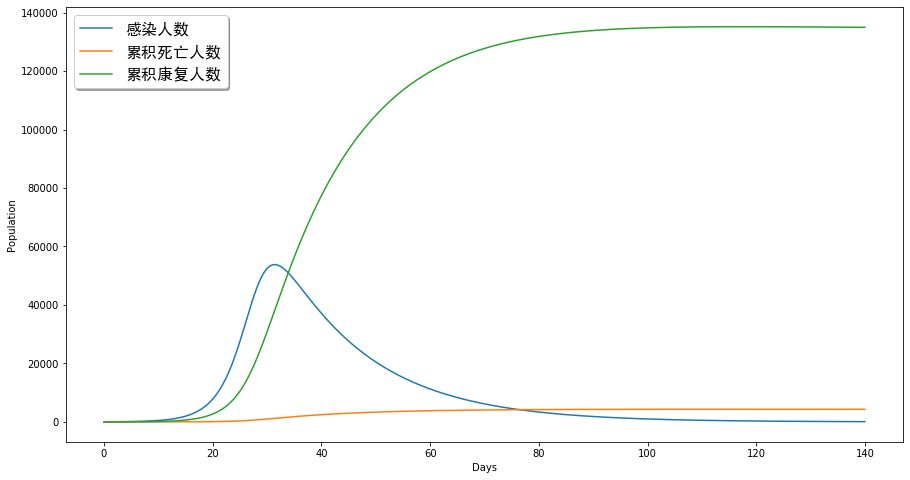

In [104]:
all_pop = np.zeros([result.shape[0]])
all_recovery = np.zeros([result.shape[0]])
for k,city in city_properties.items():
    idx = nodes[k]
    all_pop += result[:, idx] * city['pop']
    all_recovery += (1-result[:, idx]-result[:, len(nodes)+idx]) * city['pop']
plt.figure(figsize = (15,8))
country_pop = np.sum([city['pop'] for k,city in city_properties.items()])
plot_time_span = 700
death_ratio = 0.031
plt.plot(timespan[:plot_time_span],all_pop[:plot_time_span],label='感染人数')
plt.plot(timespan[:plot_time_span],all_recovery[:plot_time_span]*death_ratio, label='累积死亡人数')
plt.plot(timespan[:plot_time_span],all_recovery[:plot_time_span]*(1-death_ratio), label = '累积康复人数')
plt.xlabel('Days')
plt.ylabel('Population')
plt.legend(loc='upper left', shadow=True, numpoints = 1,fontsize=10,prop = zhfont1 )
plt.show()



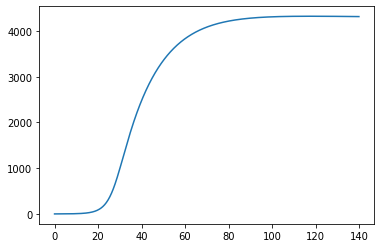

In [105]:
plt.plot(timespan[:plot_time_span],all_recovery[:plot_time_span]*death_ratio, label='累积死亡人数')
